In [17]:
from qreservoirpy import util
from qreservoirpy.reservoirs import Static

from qiskit.quantum_info import Clifford, random_clifford
from qiskit.extensions import HamiltonianGate
from qiskit.circuit.library import PauliGate
from qiskit.circuit.library import U1Gate

In [18]:
import numpy as np


class Stabilizer(Static):
    def __init__(self, n_qubits, n_ancilla, encoder, memory=np.inf, backend=None) -> None:
        super().__init__(n_qubits + 1, memory, backend)
        self.n_logical = n_qubits
        self.n_ancilla = n_ancilla
        self.encoder = encoder

        OP = random_clifford(n_qubits)

        H = util.random_ising_H(num_qubits=n_qubits, num_terms=40)
        T = 1 #s
        self.reservoir = HamiltonianGate(H, T, label="UT")

        cliff = Clifford(OP)
        ops = [elem[-self.n_logical:] for elem in cliff.stabilizer.to_labels()]
        self.ops = [PauliGate(elem).control(1) for elem in ops]

    def before(self, circuit):
        return super().before(circuit)
    def during(self, circuit, timestep):
        circuit.barrier()

        for i in range(self.n_ancilla):
            anc = self.n_logical
            circuit.initialize('+', anc)
            circuit.append(self.ops[i], [anc] + list(np.arange(self.n_logical)))
            circuit.h(anc)
            circuit.measure(anc)
        
        circuit.append(self.encoder[timestep], [0])
        circuit.append(self.encoder[timestep], [1])
        circuit.append(self.reservoir, range(self.n_logical))
    def after(self, circuit):
        return super().after(circuit)
    


In [19]:
encoder = {}
timestep = [0, 1, 2]
timeseries = timestep * 10
SHOTS = 10000
n_qubits = 4
n_ancilla = 2
for elem in np.unique(timestep):
    theta = np.random.uniform(low=-2*np.pi, high=2*np.pi)
    encoder[elem] = U1Gate(theta, str(elem))

C:\Users\otkul\AppData\Local\Temp\ipykernel_15844\771021685.py:18: DeprecationWarning: The property ``qiskit.quantum_info.operators.symplectic.clifford.Clifford.stabilizer`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Use Clifford.stab properties instead.
  ops = [elem[-self.n_logical:] for elem in cliff.stabilizer.to_labels()]


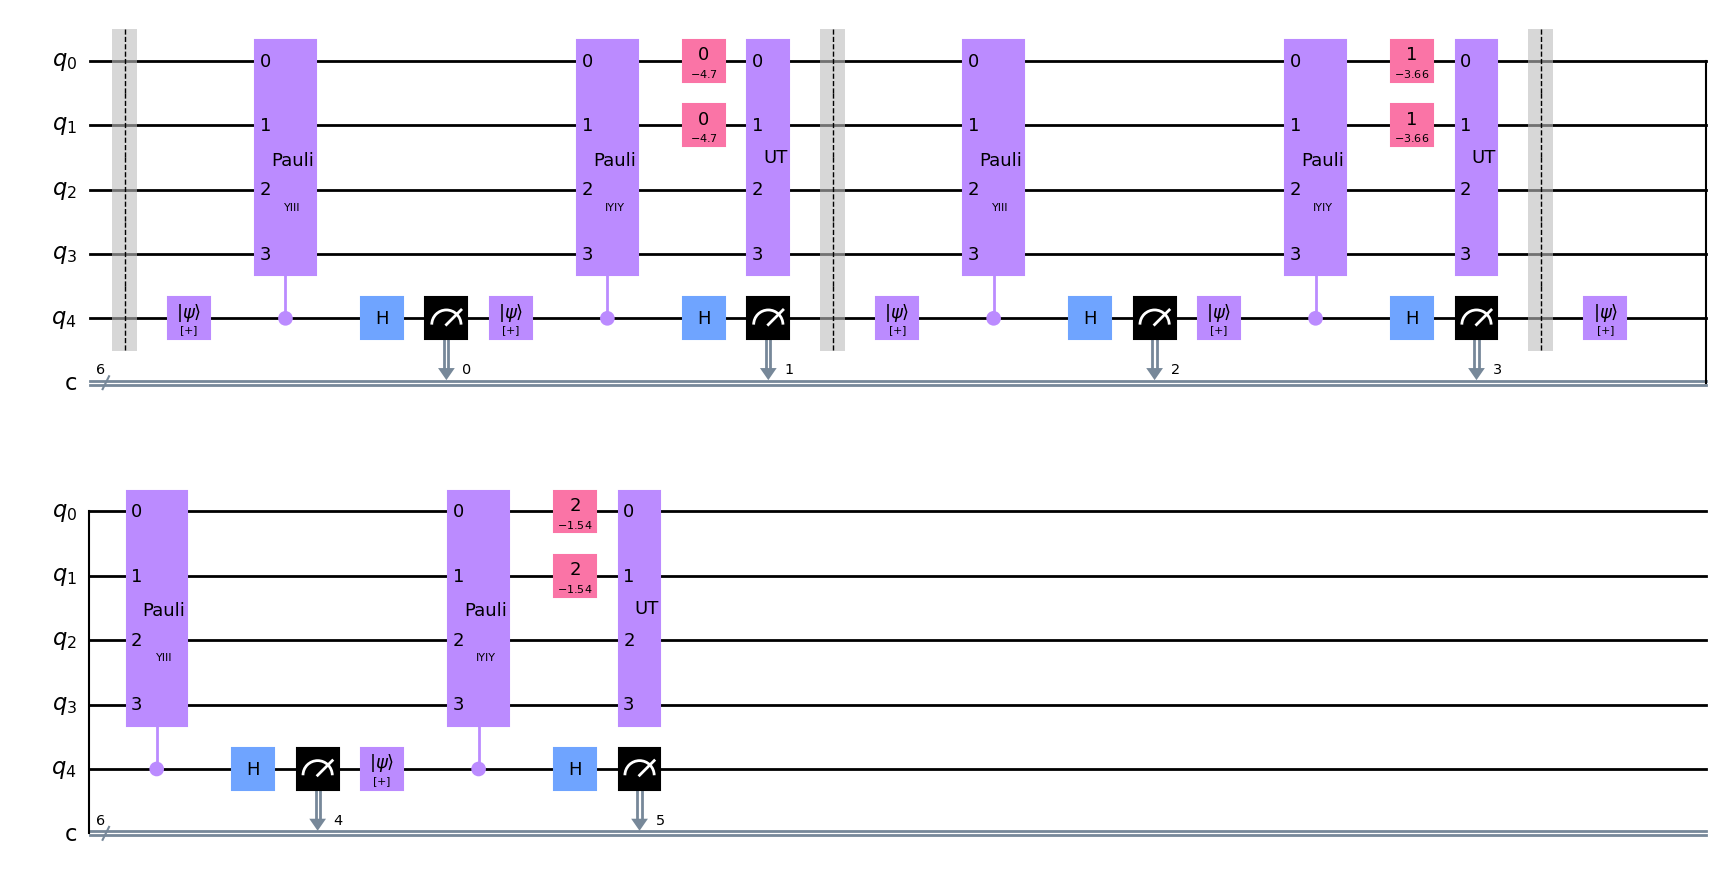

In [20]:

qres = Stabilizer(
    n_qubits=4,
    n_ancilla=2,
    encoder=encoder
)

qres.circuit([0, 1, 2], merge_registers=True, transpile=False).draw('mpl')

In [21]:
states = qres.run(
    timeseries=timeseries, 
    shots=SHOTS,
)

In [22]:

WARMUP = 0.1 # 10%
warmup_idx = int(len(states) * WARMUP)

xstates = states[warmup_idx:]
target = timeseries[warmup_idx:]


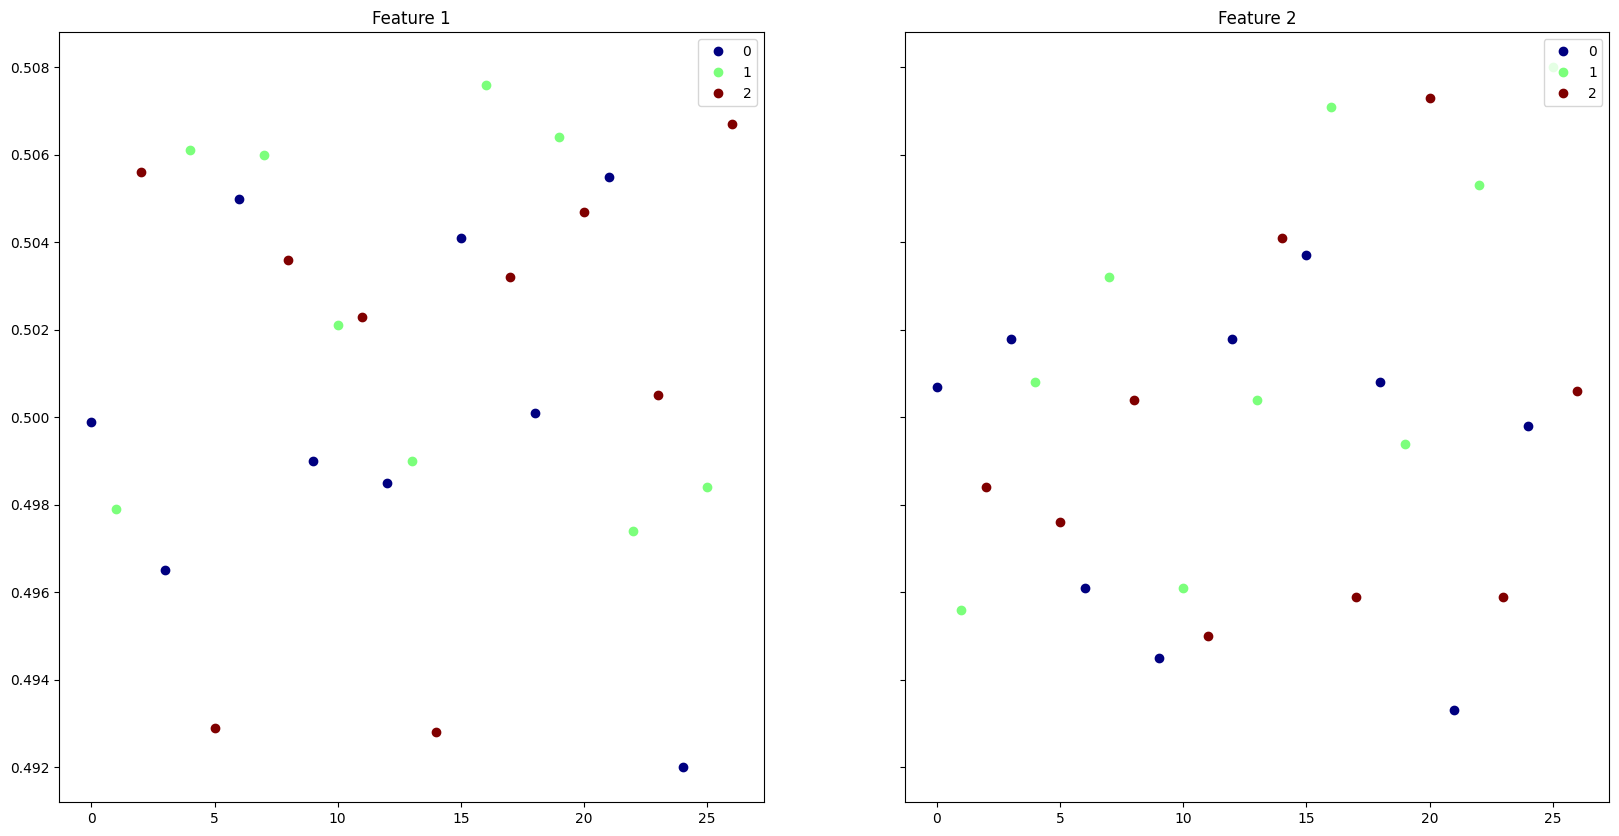

In [23]:
from qreservoirpy.plot import state_plotter
fig, ax = state_plotter(xstates, target)

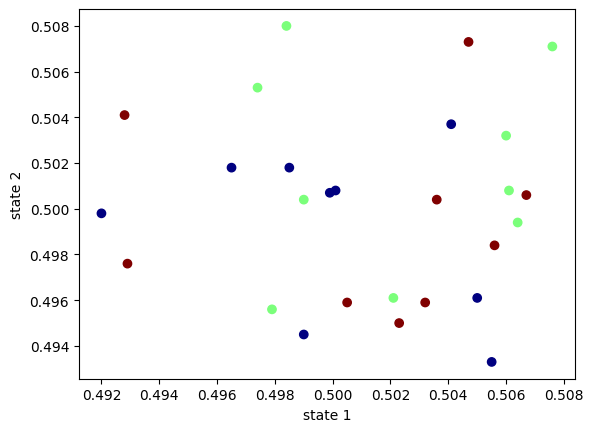

In [24]:
from qreservoirpy.plot import feature_plotter
fig, ax = feature_plotter(xstates, target)
